## Read in light curves from Kepler MAST FITS files

In [31]:
%matplotlib inline

import os
from glob import glob
import datacleaner
reload(datacleaner)
import matplotlib.pyplot as plt
from datacleaner import LightCurve, T14b2aRsi
import numpy as np
import matplotlib.gridspec as gridspec

path_to_fits_files = '/local/tmp/hat11/'
output_dir = '../lightcurves/hat11_single_transits'

# Retrieve long and short cadence data
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short_hat11')

## Calculate maximum smoothed flux for each quarter 

In [32]:
available_quarters

[0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 16, 17]

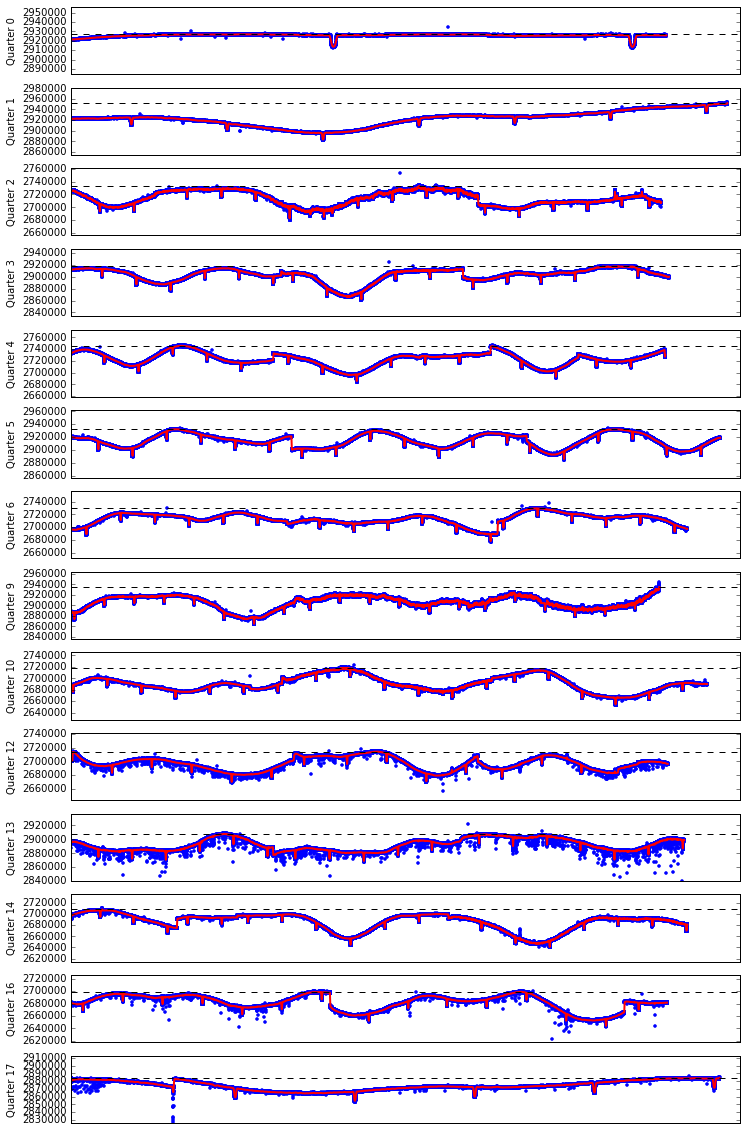

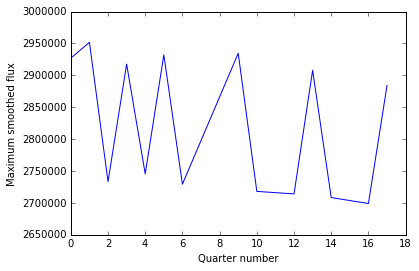

In [33]:
available_quarters = short_lc.get_available_quarters()
quarters = [short_lc.get_quarter(q) for q in short_lc.get_available_quarters()]

from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(14, 1, figsize=(12, 20))
quarterly_maxes = {}
set_upper_limit = 4e10#4e4
for i, quarter_number, lc in zip(range(len(available_quarters)), available_quarters, quarters):
    fluxes = lc.fluxes[lc.fluxes < set_upper_limit]
    smoothed_fluxes = gaussian_filter(fluxes, sigma=20)
    quarterly_maxes[quarter_number] = np.max(smoothed_fluxes)

    ax[i].plot(fluxes, '.')
    ax[i].plot(smoothed_fluxes, 'r', lw=2)
    ax[i].axhline(np.max(smoothed_fluxes), ls='--', color='k')
    ax[i].set(ylabel='Quarter {0}'.format(quarter_number), 
              ylim=[0.99*smoothed_fluxes.min(), 1.01*smoothed_fluxes.max()],
              xticks=[])
plt.show()
# plt.plot(fluxes, '.')
# plt.plot(smoothed_fluxes, 'r', lw=3)
# plt.xlim([4e4, 5.5e4])
plt.figure()
plt.plot(quarterly_maxes.keys(), quarterly_maxes.values())
plt.xlabel('Quarter number')
plt.ylabel('Maximum smoothed flux');

## Cut out transit light curves

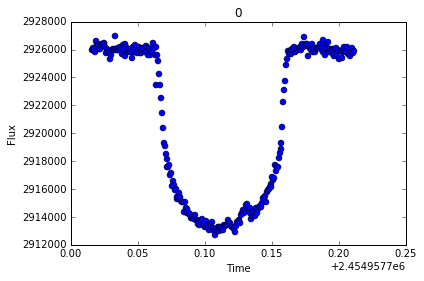

In [34]:

# Parameters from fit_transit_shallow
duration = 0.0982
b = 0.1045441000
rho_s = 1.810040
nonlinear_ld = [0, 0.86730, 0, -0.15162]

import batman
import astropy.units as u
h11_params = batman.TransitParams()

exp_time = (1*u.min).to(u.day).value
h11_params = batman.TransitParams()
h11_params.t0 = 2454605.89154                       #time of inferior conjunction
h11_params.per = 4.88780236                      #orbital period
h11_params.rp = 0.00343**0.5                      #planet radius (in units of stellar radii)

ecosw = 0.261
esinw = 0.085
eccentricity = np.sqrt(ecosw**2 + esinw**2)
omega = np.degrees(np.arccos(ecosw/eccentricity))
h11_params.ecc = eccentricity                      #eccentricity
h11_params.w = omega                       #longitude of periastron (in degrees)
a, inc = T14b2aRsi(h11_params.per, duration, b, h11_params.rp, h11_params.ecc, h11_params.w)

h11_params.a = a                       #semi-major axis (in units of stellar radii)
h11_params.inc = inc #orbital inclination (in degrees)
h11_params.u = nonlinear_ld                #limb darkening coefficients
h11_params.limb_dark = "nonlinear"       #limb darkening model
h11_params.duration = duration

short_cadence = LightCurve(name='transits_short', 
                           **short_lc.mask_out_of_transit(params=h11_params, oot_duration_fraction=0.5))
transits = short_cadence.get_transit_light_curves(params=h11_params)
transits[0].plot()

## Remove quadratic from out-of-transit near transit

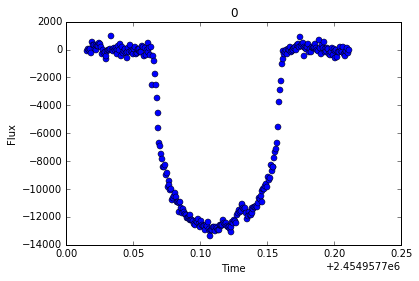

In [35]:
import warnings

# Use context manager to catch the warnings spit out by np.polyval
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for transit in transits: 
        transit.subtract_polynomial_baseline(order=2, params=h11_params)
    
transits[0].plot()

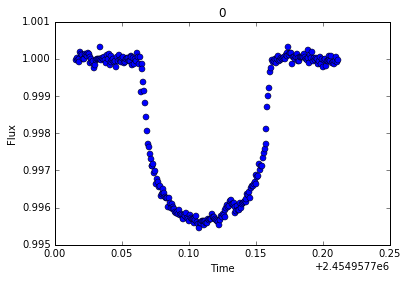

In [36]:
for transit in transits: 
    transit.fluxes += quarterly_maxes[transit.quarters[0]]
    transit.fluxes /= quarterly_maxes[transit.quarters[0]]
    transit.errors /= quarterly_maxes[transit.quarters[0]]
transits[0].plot()

## Remove incomplete transits 

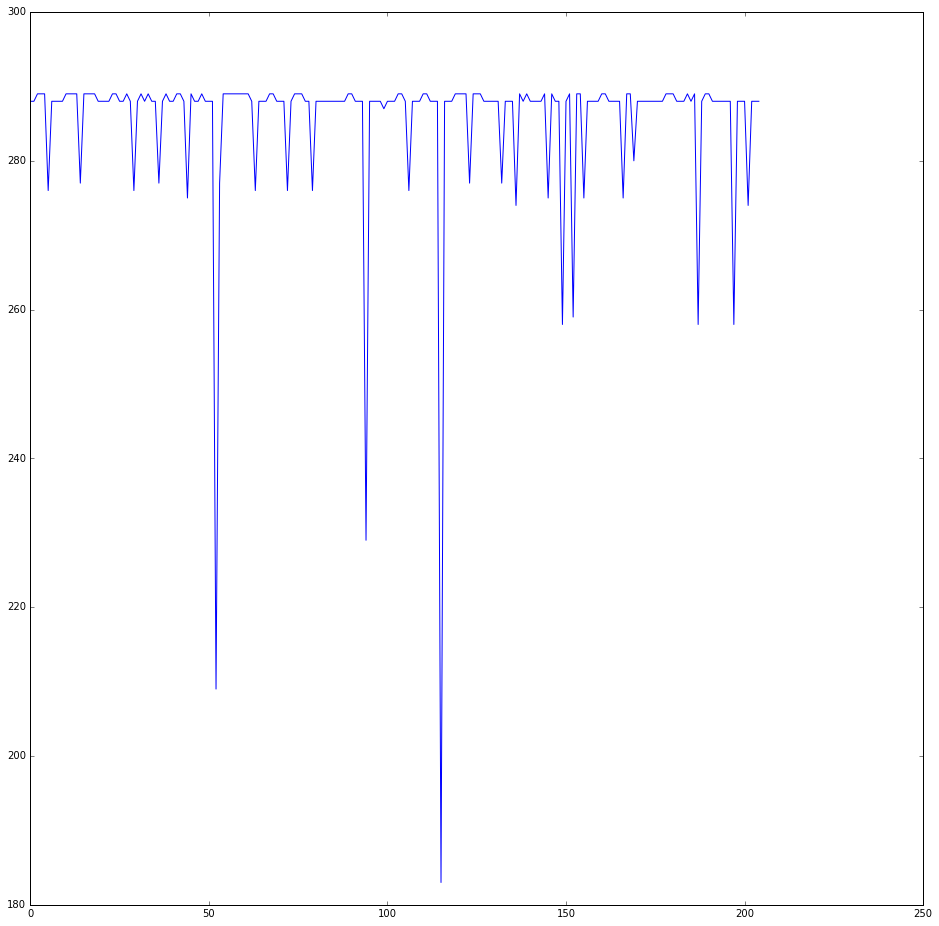

In [37]:
plt.figure(figsize=(16, 16))
plt.plot([len(transit.fluxes) for transit in transits])
transits = [transit for transit in transits if len(transit.fluxes) > 240]

In [38]:
from astropy.table import Table
from astropy.io import ascii
import os

for i, transit in enumerate(transits): 
    tbl = Table([transit.times, transit.fluxes, transit.errors], 
                names=['JD', 'Flux', 'Error'])
    ascii.write(tbl, output=os.path.join(output_dir, 'transit{0:03d}.txt'.format(i)), 
                comment='#', format='no_header')